In [1]:
%pylab inline
from matplotlib import style
style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Python modules for signal processing
from scipy.io import loadmat
from scipy import signal

# EEG example


From a patient in a dark room in a resting state. The recording is from the course **Master the Fourier transform and its applications** from Mike X.


In [3]:
data = loadmat(file_name = './data/EEGrestingState.mat')
# transpose matrix and convert to 1D NumPy array
eeg = data['eegdata'].squeeze() # amplitude in microVolts
sr = int(data['srate']) # sampling rate in sec
time = np.arange(eeg.size)/sr
print('Sampling rate = %d samples/sec'%sr)

Sampling rate = 1024 samples/sec


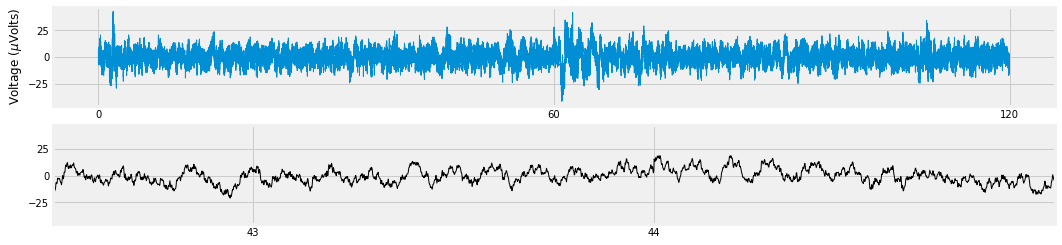

In [4]:
# plot the time course of the EEG
fig, ax = plt.subplots(2,1, figsize=(16,4), sharey=True)

ax[0].plot(time,eeg, lw=1)
ax[0].set_xlabel('Time (sec)'), ax[0].set_ylabel('Voltage ($\mu$Volts)');
ax[0].set_xticks(arange(0,130,60));

ax[1].plot(time, eeg, lw=1, color='k')
ax[1].set_xlim(42.5,45)
ax[1].set_xticks(arange(43,45,1));

In [5]:
# Fourier transform
FourierCoeff = np.fft.fft(eeg)/eeg.size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate
Nyquist = sr/2.
print('Nyquist frequency = %2.4f Hz'%Nyquist)
Nsamples = int( math.floor(eeg.size/2) )
hz = np.linspace(0, Nyquist, num = Nsamples + 1 )
print('Spectral resolution = %2.4f Hz'%hz[1])

Nyquist frequency = 512.0000 Hz
Spectral resolution = 0.0083 Hz


In [12]:
# Perform Welch's periodogram
segment = int( sr ) 
myhann = signal.get_window('hann', segment)

myparams = dict(fs = sr, nperseg = segment, window = np.ones(segment), noverlap = 0, scaling = 'spectrum', return_onesided = True)
freq, ps = signal.welch(x = eeg, **myparams)# units uV**2
print('Spectral resolution = %2.4f Hz'%freq[1])

Spectral resolution = 1.0000 Hz


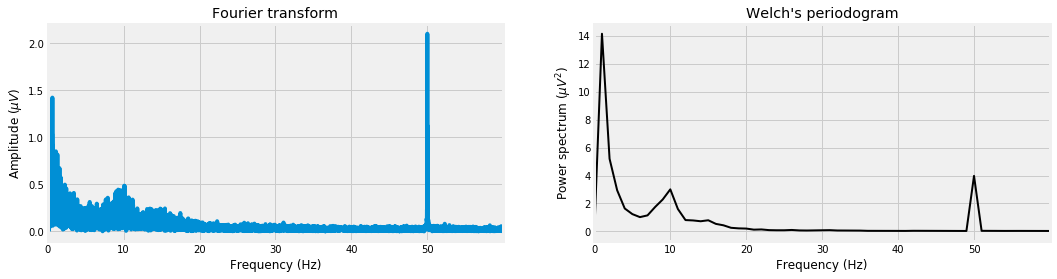

In [13]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Fourier transform")
ax[0].plot(hz,amp[:len(hz)])#, use_line_collection = True)
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Welch's periodogram")
ax[1].plot(freq, ps, color='k', lw=2) # multiply by 2 the amplitudes to have the negative frequencies
ax[1].set_ylabel('Power spectrum ($\mu V^2$)')

#ax[1].set_ylim([-1, pwr.max() * 1.1])
#ax[1].set_xlim([-1, freq.max()])

for myax in ax:
    myax.set_xlabel('Frequency (Hz)')
    myax.set_xlim(0,60)
    myticks = list(range(0,60,10))
    myax.set_xticks(myticks)

In [15]:
# now we will analyze window lenghts of 500 ms in 25 ms steps. 
# Signals will overlap 475 ms
WinLength = int(0.5*sr) # 500 points (0.5 sec, 500 ms)
step = int(0.025*sr) # 25 points (or 25 ms)

# we have less resolution here because the signals are smaller
Nsamples = int( np.floor(WinLength/2) )
hz = np.linspace(0,Nyquist, Nsamples + 1)

In [17]:
nsteps = int(np.floor ( (eeg.size - WinLength)/step) )
print(eeg.size, nsteps)

122880 4894


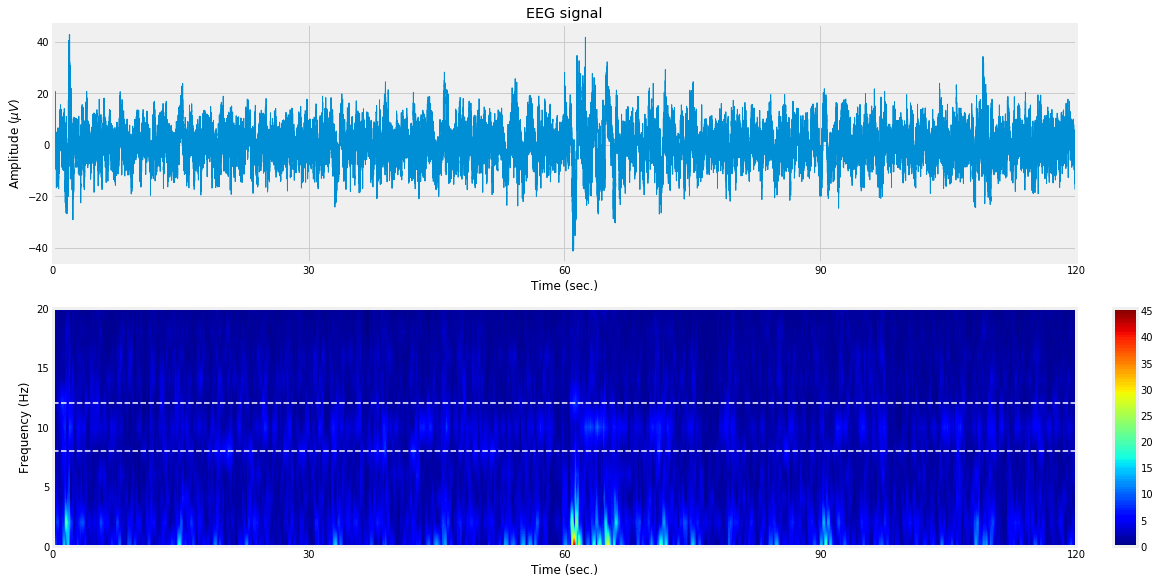

In [50]:
# time-frequency matrix
tf = np.empty( (hz.size, nsteps ))

myamp = list()
for i in range(nsteps):
    
    # slice signal
    data = eeg[i*step:i*step+WinLength]
    
    fftcoef = np.fft.fft(data)/WinLength
    myamp.append( 2*np.abs(fftcoef[:len(hz)]) )
    
# plot

fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)
#fig.suptitle('Time-frequency power via short-time FFT')

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('EEG signal')

# spectrum is a ContourSet object
dt = 120/nsteps # 5 seconds in number of steps
X = np.arange(nsteps)*dt
Y = hz
Z = np.array(myamp).T
levels = 100
spectrum = ax[1].contourf(X,Y,Z,levels,cmap='jet')#,'linecolor','none')
ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,20])
ax[1].set_yticks(arange(0,25,5))
ax[1].set_ylabel('Frequency (Hz)')

fig.colorbar(spectrum, fraction = 0.05)#, ticks = np.arange(0,1.2,.2))

for myax in ax:
    myax.set_xlim(0, 120)
    myax.set_xticks(np.arange(0, 121, 30))
    myax.set_xlabel('Time (sec.)')